# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 25 May 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "16-49, not in other eligible groups shown":0 
        # NB the key for the final group (0) must contain phrase "not in other eligible groups"
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"
                                      )]
other = ["sex","ageband", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories",
                              "bmi","chronic_cardiac_disease", "current_copd", "dmards","ssri"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    other, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [12]:
# for details on second doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

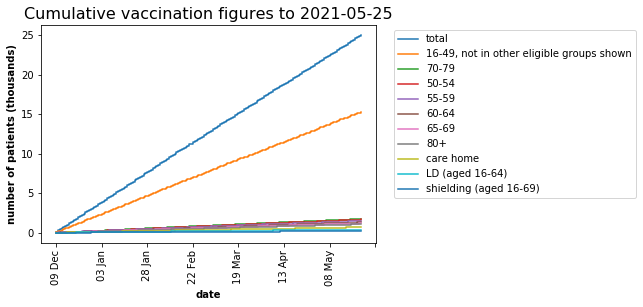

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [15]:
from report_results import summarise_data_by_group

In [16]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [17]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [18]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [19]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [20]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

In [21]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)))    
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 25 May 2021,second dose as at 25 May 2021
Total vaccinated in TPP,"24,997","15,001"
80+,"50.4% (1,064 of 2,114)","29.0% (616 of 2,114)"
70-79,"49.6% (1,729 of 3,486)","30.6% (1,071 of 3,486)"
care home,"51.3% (693 of 1,351)","28.9% (392 of 1,351)"
shielding (aged 16-69),48.4% (210 of 434),29.5% (126 of 434)
65-69,"51.4% (1,169 of 2,275)","30.2% (686 of 2,275)"
LD (aged 16-64),49.3% (392 of 791),28.4% (224 of 791)
60-64,"48.9% (1,309 of 2,674)","31.9% (854 of 2,674)"
55-59,"49.0% (1,484 of 3,024)","29.8% (903 of 3,024)"
50-54,"50.0% (1,666 of 3,332)","29.7% (994 of 3,332)"


*
 figures rounded to nearest 7

In [22]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Oxford-AZ vaccines (% of all first doses): **0.0%** (7)

Pfizer vaccines (% of all first doses): **0.2%** (49)

Moderna vaccines (% of all first doses): **0.0%** (0)

Second doses (% of all vaccinated): **60.0%** (15,001)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **2.1%** (315)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.3%** (49)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **1.2%** (182)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [23]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout (first dose) among **80+** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1065   
sex                       F                                           518   
                          M                                           546   
ageband_5yr               0                                            63   
                          0-15                                         70   
                          16-29                                        56   
                          30-34                                        77   
                          35-39                                        56   
                          40-44                                        63   
                          45-49                                        56   
                          50-54                                        84   
                          55-59                                        70   
                          60-64                                        63   
                          65-69                                        63   
                          70-74                                        70   
                          75-79                                        56   
                          80-84                                        70   
                          85-89                                        77   
                          90+                                          70   
ethnicity_6_groups        Black                                       189   
                          Mixed                                       168   
                          Other                                       175   
                          South Asian                                 182   
                          Unknown                                     154   
                          White                                       196   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   63   
                           Chinese                                     63   
                           Other                                       63   
                           Other Asian                                 49   
                          British or Mixed British                     49   
                          Indian or British Indian                     56   
                          Irish                                        63   
                          Other Black                                  56   
                          Other White                                  49   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               56   
                          Unknown                                     154   
                          White + Asian                                49   
                          White + Black African                        63   
                          White + Black Caribbean                      63   
imd_categories            1 Most deprived                             203   
                          2                                           203   
                          3                                           196   
                          4                                           210   
                          5 Least deprived                            203   
                          Unknown                                      49   
bmi                       30+                                         343   
                          under 30                                    728   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose) among **70-79** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1728   
sex                       F                                           889   
                          M                                           833   
ageband_5yr               0                                            98   
                          0-15                                        119   
                          16-29                                        98   
                          30-34                                        98   
                          35-39                                        91   
                          40-44                                       126   
                          45-49                                       126   
                          50-54                                       112   
                          55-59                                       112   
                          60-64                                       105   
                          65-69                                        98   
                          70-74                                       126   
                          75-79                                       112   
                          80-84                                        91   
                          85-89                                       105   
                          90+                                         112   
ethnicity_6_groups        Black                                       280   
                          Mixed                                       287   
                          Other                                       287   
                          South Asian                                 301   
                          Unknown                                     273   
                          White                                       294   
ethnicity_16_groups        African                                     84   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   98   
                           Chinese                                     98   
                           Other                                       77   
                           Other Asian                                 84   
                          British or Mixed British                     84   
                          Indian or British Indian                     91   
                          Irish                                        91   
                          Other Black                                 105   
                          Other White                                  98   
                          Other mixed                                 119   
                          Pakistani or British Pakistani               91   
                          Unknown                                     273   
                          White + Asian                                77   
                          White + Black African                        84   
                          White + Black Caribbean                      98   
imd_categories            1 Most deprived                             350   
                          2                                           301   
                          3                                           343   
                          4                                           336   
                          5 Least deprived                            322   
                          Unknown                                      77   
bmi                       30+                                         497   
                          under 30                                   1232   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose) among **care home** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             693     51.3   1351   
sex                F                   364     53.1    686   
                   M                   329     49.0    672   
ageband_5yr        0                    42     50.0     84   
                   0-15                 42     42.9     98   
                   16-29                35     45.5     77   
                   30-34                49     58.3     84   
                   35-39                42     60.0     70   
                   40-44                42     50.0     84   
                   45-49                35     50.0     70   
                   50-54                42     46.2     91   
                   55-59                35     50.0     70   
                   60-64                42     54.5     77   
                   65-69                42     54.5     77   
                   70-74                42     46.2     91   
                   75-79                49     53.8     91   
                   80-84                56     57.1     98   
                   85-89                49     50.0     98   
                   90+                  49     50.0     98   
ethnicity_6_groups Black                98     48.3    203   
                   Mixed               119     48.6    245   
                   Other               119     51.5    231   
                   South Asian         112     53.3    210   
                   Unknown             126     54.5    231   
                   White               112     50.0    224   
dementia           no                  686     51.0   1344   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 48.8   
sex                F                                         50   
                   M                                       46.9   
ageband_5yr        0                                         50   
                   0-15                                    42.9   
                   16-29                                   45.5   
                   30-34                                   58.3   
                   35-39                                     60   
                   40-44                                   41.7   
                   45-49                                     50   
                   50-54                                   46.2   
                   55-59                                     50   
                   60-64                                   54.5   
                   65-69                                   54.5   
                   70-74                                   38.5   
                   75-79                                   53.8   
                   80-84                                     50   
                   85-89                                     50   
                   90+                                       50   
ethnicity_6_groups Black                                   44.8   
                   Mixed                                   48.6   
                   Other                                   48.5   
                   South Asian                             53.3   
                   Unknown                                 54.5   
                   White                                   46.9   
dementia           no                                        49   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               2.5   
sex                F                                     3.1   
                   M             

## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  210     48.4    434   
newly_shielded_since_feb_15 no                       210     49.2    427   
                            yes                        0      0.0      0   
sex                         F                         98     48.3    203   
                            M                        112     50.0    224   
ageband                     16-29                     21     42.9     49   
                            30-39                     28     50.0     56   
                            40-49                     28     50.0     56   
                            50-59                     21     37.5     56   
                            60-69                     28     50.0     56   
                            70-79                     56     53.3    105   
                            80+                       35     62.5     56   
ethnicity_6_groups          Black                     28     36.4     77   
                            Mixed                     28     36.4     77   
                            Other                     42     60.0     70   
                            South Asian               42     54.5     77   
                            Unknown                   28     44.4     63   
                            White                     42     54.5     77   
imd_categories              1 Most deprived           42     42.9     98   
                            2                         42     42.9     98   
                            3                         35     45.5     77   
                            4                         35     50.0     70   
                            5 Least deprived          42     60.0     70   
                            Unknown                    7     33.3     21   
LD                          no                       210     49.2    427   
                            yes                        0      0.0      7   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      45.9   
newly_shielded_since_feb_15 no                                           45.9   
                            yes                                           NaN   
sex                         F                                            44.8   
                            M                                            46.9   
ageband                     16-29                                        28.6   
                            30-39                                          50   
                            40-49                                        37.5   
                            50-59                                        37.5   
                            60-69                                          50   
                            70-79                                        46.7   
                            80+                                          62.5   
ethnicity_6_groups          Black                                        36.4   
                            Mixed                                        36.4   
                            Other                                          60   
                            South Asian                                  45.5   
                            Unknown                                      44.4   
                            White                                        45.5   
imd_categories              1 Most deprived                              42.9   
                            2                                            42.9   
                            3                                            36.4   
                            4                         

## 

## COVID vaccination rollout (first dose) among **65-69** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1170   
sex                       F                                           595   
                          M                                           574   
ethnicity_6_groups        Black                                       203   
                          Mixed                                       217   
                          Other                                       203   
                          South Asian                                 203   
                          Unknown                                     154   
                          White                                       189   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   56   
                           Chinese                                     70   
                           Other                                       49   
                           Other Asian                                 56   
                          British or Mixed British                     56   
                          Indian or British Indian                     70   
                          Irish                                        63   
                          Other Black                                  77   
                          Other White                                  63   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               63   
                          Unknown                                     182   
                          White + Asian                                70   
                          White + Black African                        63   
                          White + Black Caribbean                      56   
imd_categories            1 Most deprived                             210   
                          2                                           231   
                          3                                           210   
                          4                                           238   
                          5 Least deprived                            217   
                          Unknown                                      56   
bmi                       30+                                         329   
                          under 30                                    840   
chronic_cardiac_disease   no                                         1155   
                          yes                                          14   
current_copd              no                                         1155   
                          yes                                          14   
dmards                    no                                         1162   
                          yes                                           7   
dementia                  no                                         1155   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1162   
                          yes                                           7   
LD                        no                                         1155   
                          yes                                          14   
ssri                      no                                         1155   
                          yes                                          14   
chemo_or_radio            no                                         1162   
                          yes                                          14   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             390     49.3    791   
sex                F                   203     49.2    413   
                   M                   189     50.0    378   
ageband_5yr        0                    21     42.9     49   
                   0-15                 21     42.9     49   
                   16-29                21     50.0     42   
                   30-34                21     42.9     49   
                   35-39                28     57.1     49   
                   40-44                21     60.0     35   
                   45-49                28     57.1     49   
                   50-54                28     50.0     56   
                   55-59                21     50.0     42   
                   60-64                21     42.9     49   
                   65-69                28     44.4     63   
                   70-74                28     44.4     63   
                   75-79                35     62.5     56   
                   80-84                21     50.0     42   
                   85-89                28     57.1     49   
                   90+                  21     42.9     49   
ethnicity_6_groups Black                49     41.2    119   
                   Mixed                70     50.0    140   
                   Other                77     55.0    140   
                   South Asian          56     42.1    133   
                   Unknown              63     52.9    119   
                   White                77     52.4    147   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 47.4   
sex                F                                       47.5   
                   M                                       48.1   
ageband_5yr        0                                       42.9   
                   0-15                                    42.9   
                   16-29                                     50   
                   30-34                                   42.9   
                   35-39                                   57.1   
                   40-44                                     40   
                   45-49                                   57.1   
                   50-54                                     50   
                   55-59                                     50   
                   60-64                                   42.9   
                   65-69                                   44.4   
                   70-74                                   33.3   
                   75-79                                     50   
                   80-84                                     50   
                   85-89                                   57.1   
                   90+                                     42.9   
ethnicity_6_groups Black                                   41.2   
                   Mixed                                     50   
                   Other                                     50   
                   South Asian                             36.8   
                   Unknown                                 52.9   
                   White                                   47.6   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.9   
sex                F                                     1.7   
                   M                                     1.9   
ageband_5yr        0                                       0   
                   0-15                                    0   
                   16-29                                   0   
                   30-34           

## 

## COVID vaccination rollout (first dose) among **60-64** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1307   
sex                       F                                           658   
                          M                                           644   
ethnicity_6_groups        Black                                       203   
                          Mixed                                       210   
                          Other                                       245   
                          South Asian                                 210   
                          Unknown                                     217   
                          White                                       224   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   63   
                           Chinese                                     56   
                           Other                                       56   
                           Other Asian                                 84   
                          British or Mixed British                     70   
                          Indian or British Indian                     63   
                          Irish                                        77   
                          Other Black                                  63   
                          Other White                                  70   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               77   
                          Unknown                                     217   
                          White + Asian                                70   
                          White + Black African                        84   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             259   
                          2                                           245   
                          3                                           252   
                          4                                           238   
                          5 Least deprived                            259   
                          Unknown                                      63   
bmi                       30+                                         392   
                          under 30                                    917   
chronic_cardiac_disease   no                                         1295   
                          yes                                           7   
current_copd              no                                         1295   
                          yes                                          14   
dmards                    no                                         1288   
                          yes                                          14   
dementia                  no                                         1295   
                          yes                                           7   
psychosis_schiz_bipolar   no                                         1295   
                          yes                                          14   
ssri                      no                                         1295   
                          yes                                          14   
chemo_or_radio            no                                         1288   
                          yes                                          21   
lung_cancer               no                                         1302   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose) among **55-59** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1481   
sex                     F                                           763   
                        M                                           721   
ethnicity_6_groups      Black                                       259   
                        Mixed                                       287   
                        Other                                       252   
                        South Asian                                 231   
                        Unknown                                     217   
                        White                                       231   
ethnicity_16_groups      African                                     84   
                         Bangladeshi or British Bangladeshi          70   
                         Caribbean                                   63   
                         Chinese                                     91   
                         Other                                       84   
                         Other Asian                                 84   
                        British or Mixed British                     91   
                        Indian or British Indian                     84   
                        Irish                                        70   
                        Other Black                                  91   
                        Other White                                  84   
                        Other mixed                                  77   
                        Pakistani or British Pakistani               84   
                        Unknown                                     210   
                        White + Asian                                70   
                        White + Black African                        77   
                        White + Black Caribbean                      77   
imd_categories          1 Most deprived                             259   
                        2                                           315   
                        3                                           287   
                        4                                           294   
                        5 Least deprived                            252   
                        Unknown                                      70   
bmi                     30+                                         476   
                        under 30                                   1008   
chronic_cardiac_disease no                                         1463   
                        yes                                          21   
current_copd            no                                         1470   
                        yes                                          14   
dmards                  no                                         1470   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1470   
                        yes                                          14   
ssri                    no                                         1463   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 49.0   3024   
sex                     F                                       49.1   1554   
                        M                                       49.0   1470   
ethnicity_6_groups      Black                                   54.4    476   
                        Mixed                                   51.2    560   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **50-54** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1665   
sex                     F                                           847   
                        M                                           812   
ethnicity_6_groups      Black                                       301   
                        Mixed                                       301   
                        Other                                       266   
                        South Asian                                 252   
                        Unknown                                     266   
                        White                                       280   
ethnicity_16_groups      African                                     91   
                         Bangladeshi or British Bangladeshi          91   
                         Caribbean                                   91   
                         Chinese                                     77   
                         Other                                       98   
                         Other Asian                                 84   
                        British or Mixed British                    105   
                        Indian or British Indian                    105   
                        Irish                                        77   
                        Other Black                                  91   
                        Other White                                  77   
                        Other mixed                                  84   
                        Pakistani or British Pakistani               84   
                        Unknown                                     245   
                        White + Asian                                91   
                        White + Black African                        70   
                        White + Black Caribbean                      98   
imd_categories          1 Most deprived                             294   
                        2                                           294   
                        3                                           308   
                        4                                           322   
                        5 Least deprived                            336   
                        Unknown                                     105   
bmi                     30+                                         518   
                        under 30                                   1148   
chronic_cardiac_disease no                                         1652   
                        yes                                           7   
current_copd            no                                         1652   
                        yes                                          14   
dmards                  no                                         1652   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1638   
                        yes                                          28   
ssri                    no                                         1645   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 50.0   3332   
sex                     F                                       48.4   1750   
                        M                                       51.3   1582   
ethnicity_6_groups      Black                                   51.8    581   
                        Mixed                                   51.8    581   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **16-49, not in other eligible groups shown** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                   15291   
sex                     F                                          7826   
                        M                                          7462   
ageband                 16-29                                      1932   
                        30-39                                      1918   
                        40-49                                      1953   
                        50-59                                      1834   
                        60-69                                      1890   
                        70-79                                      3843   
                        80+                                        1918   
ethnicity_6_groups      Black                                      2653   
                        Mixed                                      2667   
                        Other                                      2541   
                        South Asian                                2534   
                        Unknown                                    2338   
                        White                                      2555   
ethnicity_16_groups      African                                    847   
                         Bangladeshi or British Bangladeshi         805   
                         Caribbean                                  854   
                         Chinese                                    798   
                         Other                                      805   
                         Other Asian                                826   
                        British or Mixed British                    805   
                        Indian or British Indian                    854   
                        Irish                                       812   
                        Other Black                                 763   
                        Other White                                 770   
                        Other mixed                                 805   
                        Pakistani or British Pakistani              819   
                        Unknown                                    2282   
                        White + Asian                               826   
                        White + Black African                       819   
                        White + Black Caribbean                     791   
imd_categories          1 Most deprived                            2856   
                        2                                          2933   
                        3                                          2919   
                        4                                          2926   
                        5 Least deprived                           2891   
                        Unknown                                     763   
bmi                     30+                                        4627   
                        under 30                                  10668   
chronic_cardiac_disease no                                        15141   
                        yes                                         154   
current_copd            no                                        15134   
                        yes                                         154   
dmards                  no                                        15162   
                        yes                                         133   
ssri                    no                                        15134   
                        yes                                         154   

                                                            vaccinated 7d previous  \
category                group                                                        
overall                 overall                                

# Demographics time trend charts

In [24]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 25 May 2021

### COVID vaccinations among **80+** population by **sex**

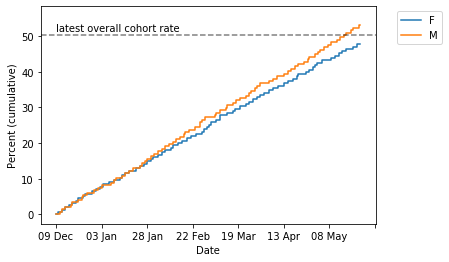

### COVID vaccinations among **80+** population by **ageband 5yr**

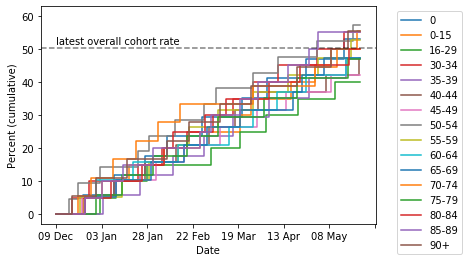

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

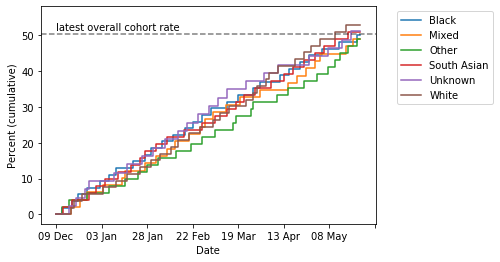

### COVID vaccinations among **80+** population by **imd categories**

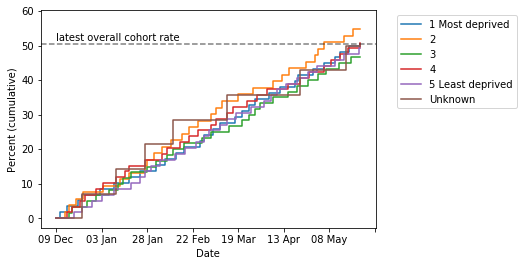

### COVID vaccinations among **80+** population by **bmi**

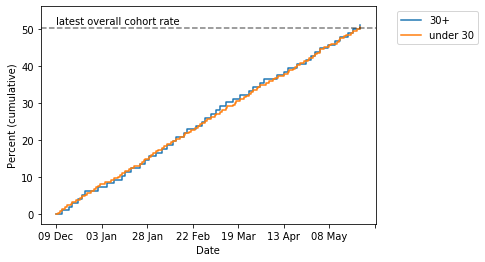

### COVID vaccinations among **80+** population by **chronic cardiac disease**

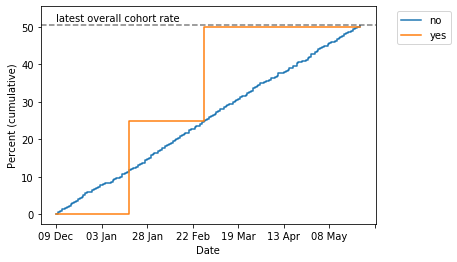

### COVID vaccinations among **80+** population by **current copd**

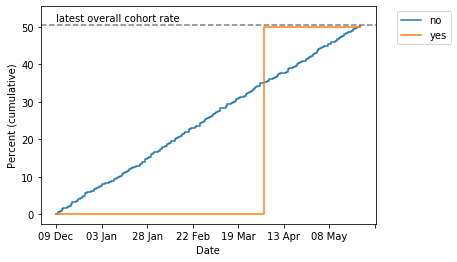

### COVID vaccinations among **80+** population by **dialysis**

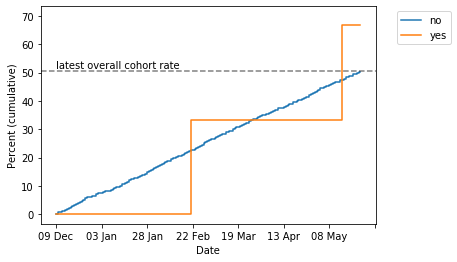

### COVID vaccinations among **80+** population by **dementia**

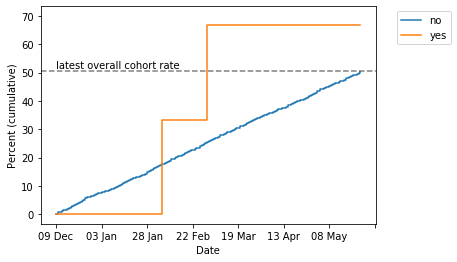

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

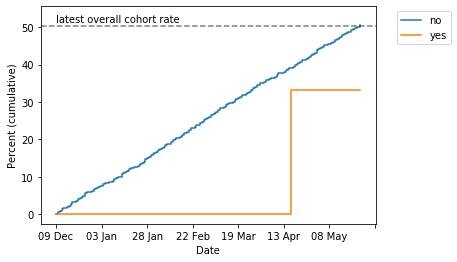

### COVID vaccinations among **80+** population by **LD**

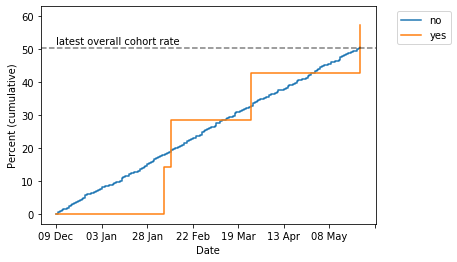

### COVID vaccinations among **80+** population by **ssri**

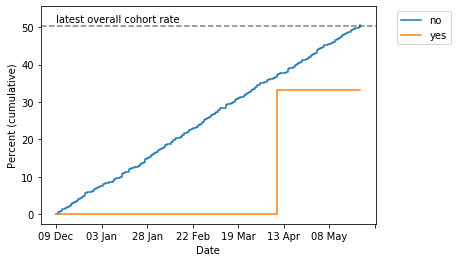

## 
 ## COVID vaccination rollout among **70-79** population up to 25 May 2021

### COVID vaccinations among **70-79** population by **sex**

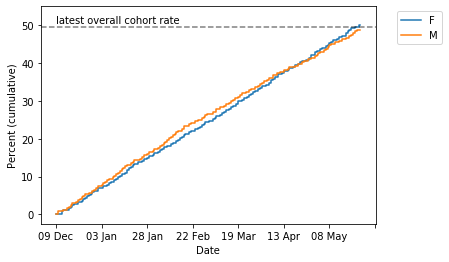

### COVID vaccinations among **70-79** population by **ageband 5yr**

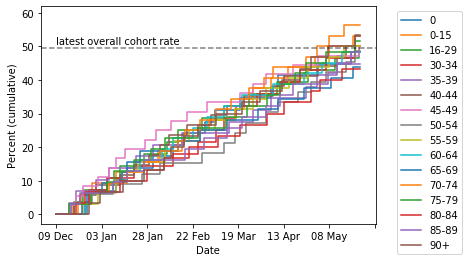

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

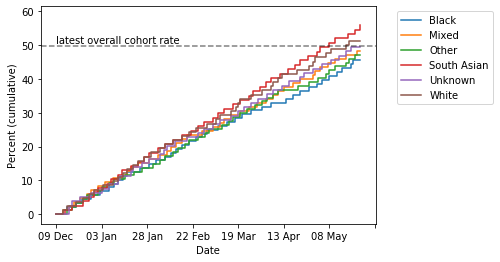

### COVID vaccinations among **70-79** population by **imd categories**

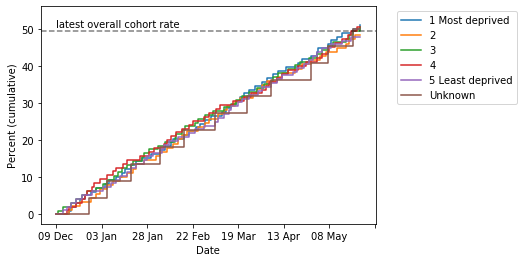

### COVID vaccinations among **70-79** population by **bmi**

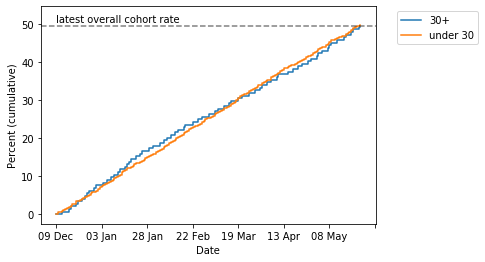

### COVID vaccinations among **70-79** population by **chronic cardiac disease**

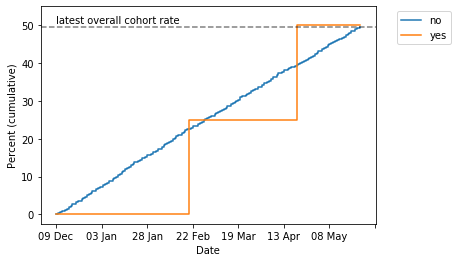

### COVID vaccinations among **70-79** population by **current copd**

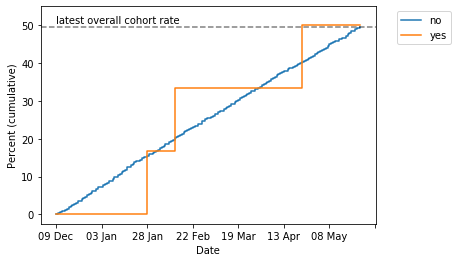

### COVID vaccinations among **70-79** population by **dialysis**

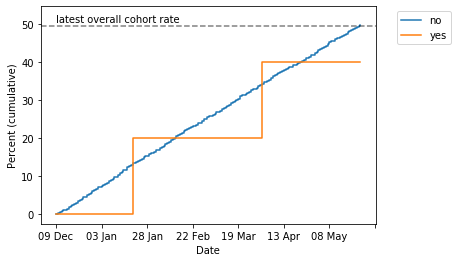

### COVID vaccinations among **70-79** population by **dementia**

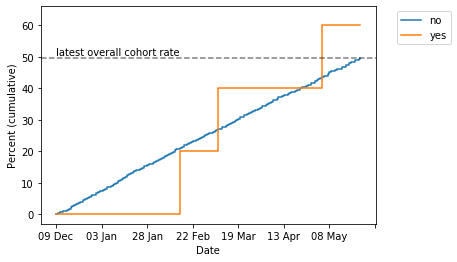

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

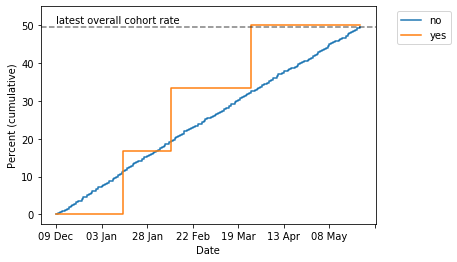

### COVID vaccinations among **70-79** population by **LD**

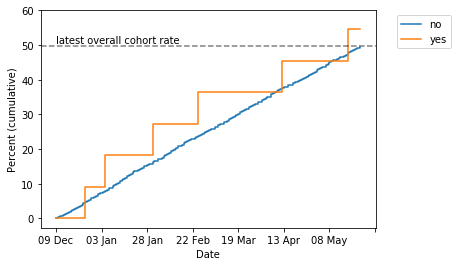

### COVID vaccinations among **70-79** population by **ssri**

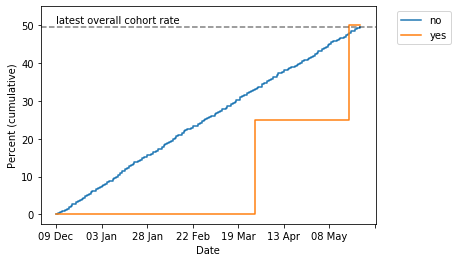

## 
 ## COVID vaccination rollout among **65-69** population up to 25 May 2021

### COVID vaccinations among **65-69** population by **sex**

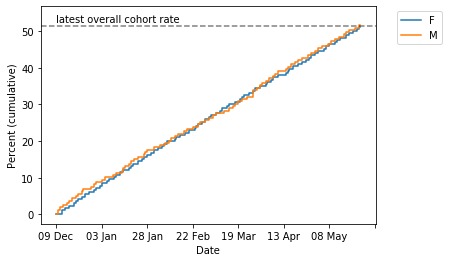

### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

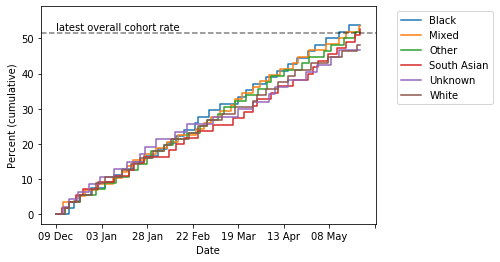

### COVID vaccinations among **65-69** population by **imd categories**

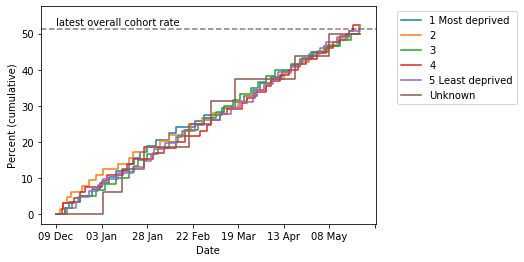

### COVID vaccinations among **65-69** population by **bmi**

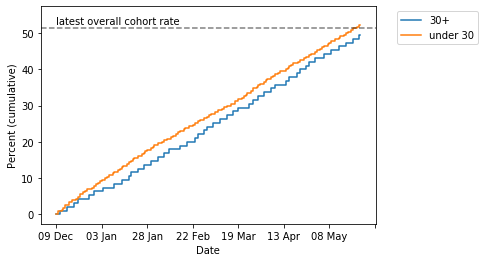

### COVID vaccinations among **65-69** population by **chronic cardiac disease**

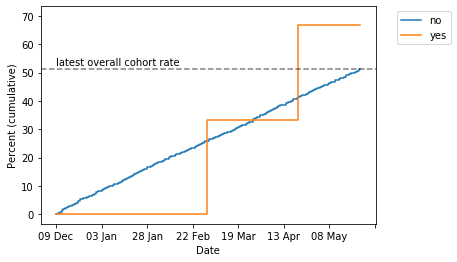

### COVID vaccinations among **65-69** population by **current copd**

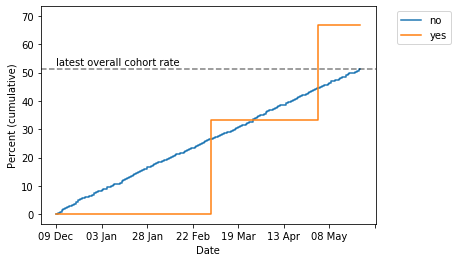

### COVID vaccinations among **65-69** population by **dementia**

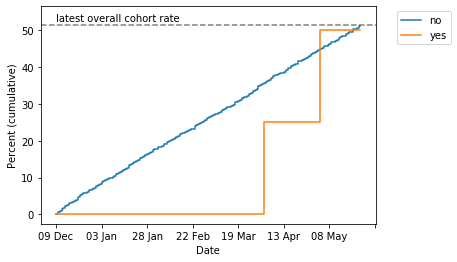

### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

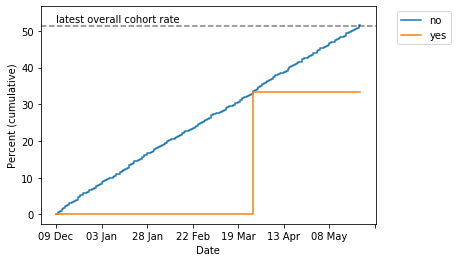

### COVID vaccinations among **65-69** population by **LD**

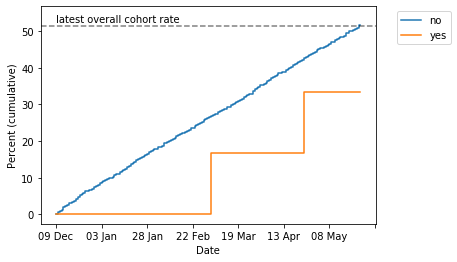

### COVID vaccinations among **65-69** population by **ssri**

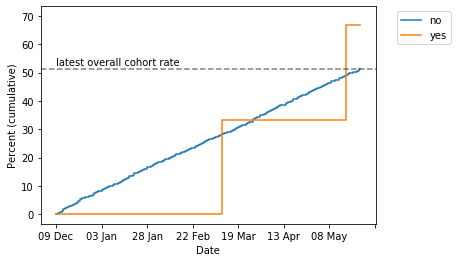

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 25 May 2021

### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

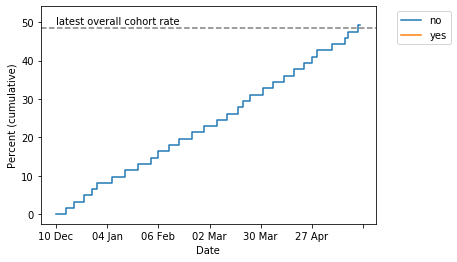

### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

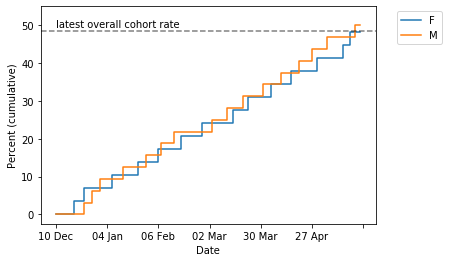

### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

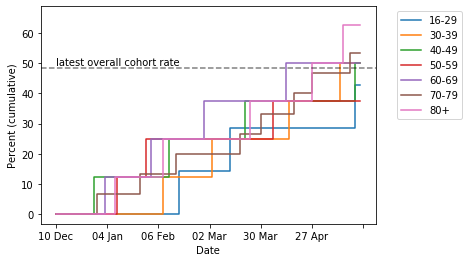

### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

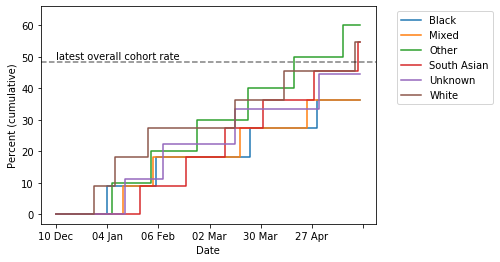

### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

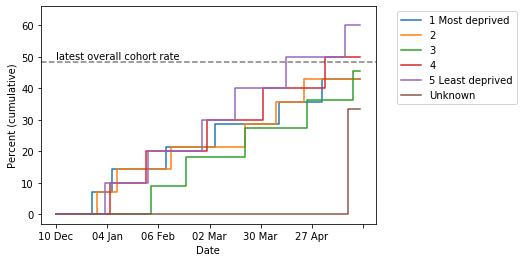

### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

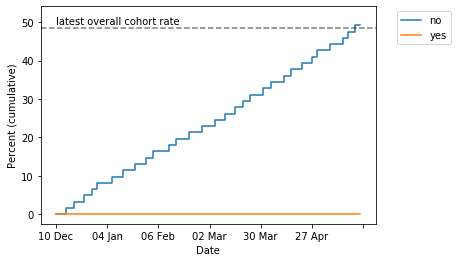

## 
 ## COVID vaccination rollout among **60-64** population up to 25 May 2021

### COVID vaccinations among **60-64** population by **sex**

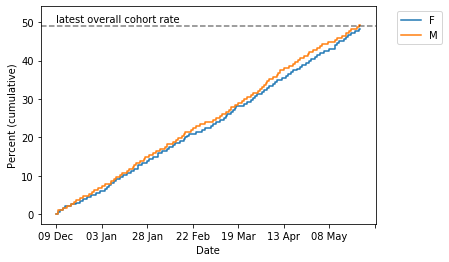

### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

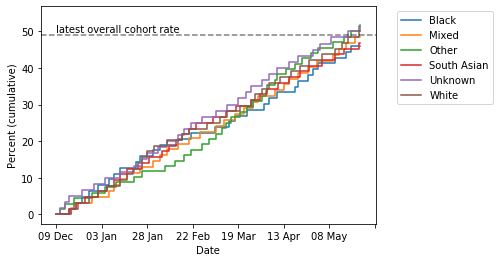

### COVID vaccinations among **60-64** population by **imd categories**

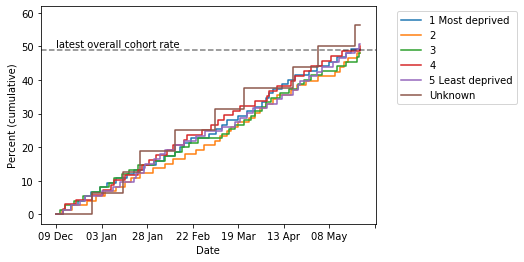

### COVID vaccinations among **60-64** population by **bmi**

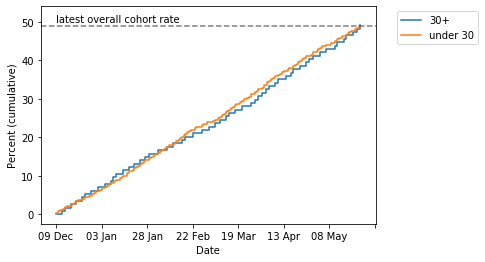

### COVID vaccinations among **60-64** population by **chronic cardiac disease**

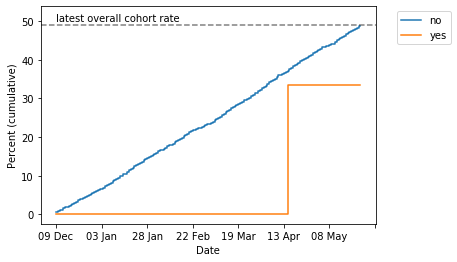

### COVID vaccinations among **60-64** population by **current copd**

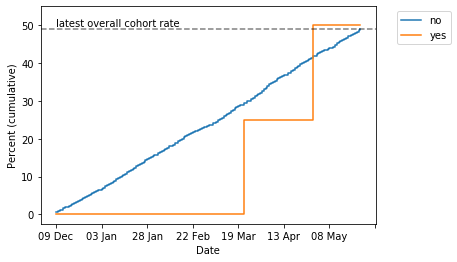

### COVID vaccinations among **60-64** population by **dementia**

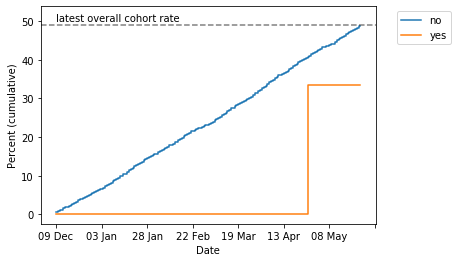

### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

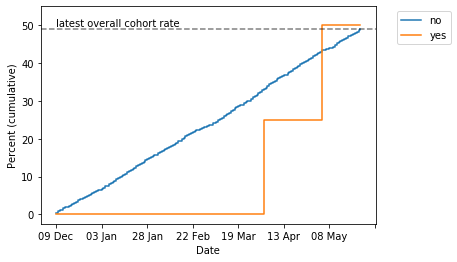

### COVID vaccinations among **60-64** population by **ssri**

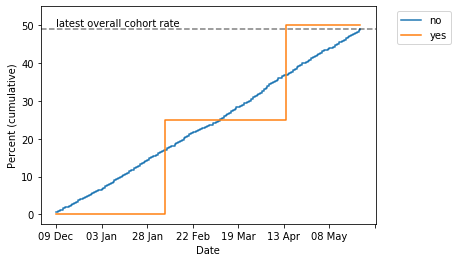

## 
 ## COVID vaccination rollout among **55-59** population up to 25 May 2021

### COVID vaccinations among **55-59** population by **sex**

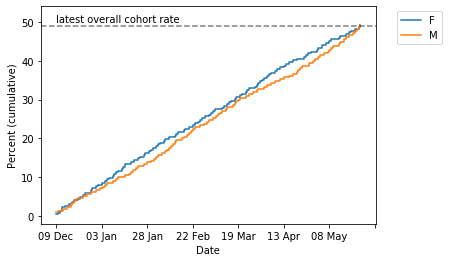

### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

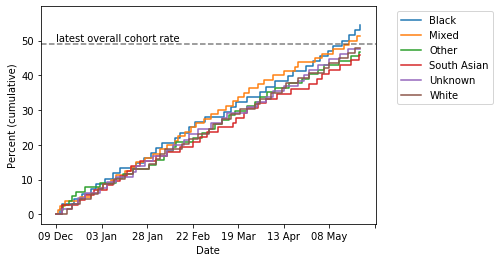

### COVID vaccinations among **55-59** population by **imd categories**

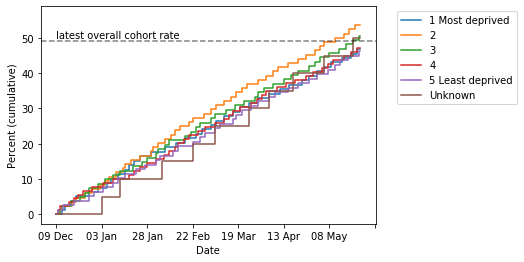

### COVID vaccinations among **55-59** population by **bmi**

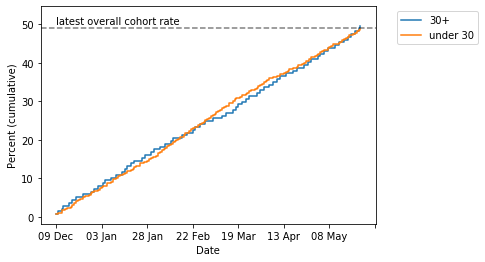

### COVID vaccinations among **55-59** population by **chronic cardiac disease**

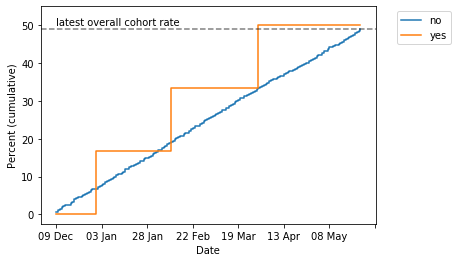

### COVID vaccinations among **55-59** population by **current copd**

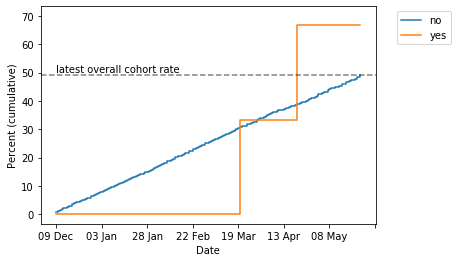

### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

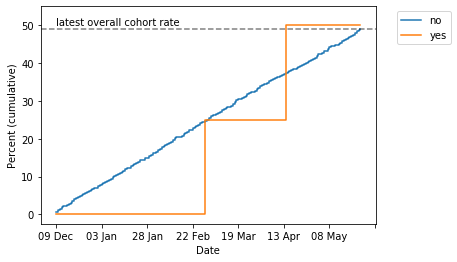

### COVID vaccinations among **55-59** population by **ssri**

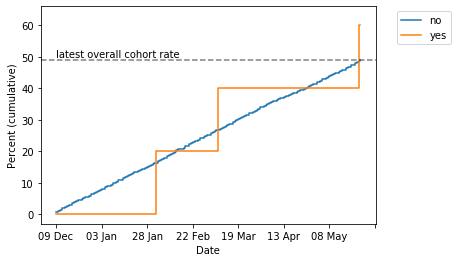

## 
 ## COVID vaccination rollout among **50-54** population up to 25 May 2021

### COVID vaccinations among **50-54** population by **sex**

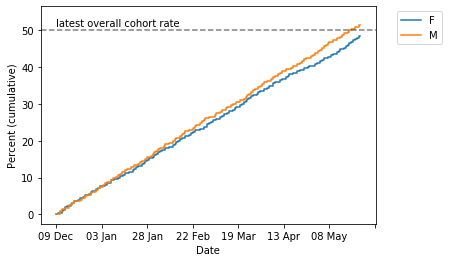

### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

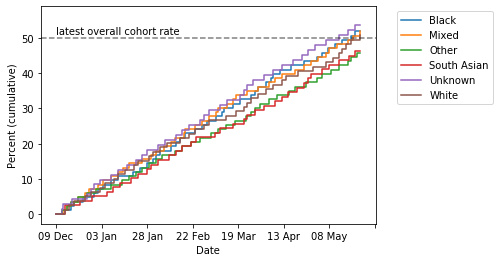

### COVID vaccinations among **50-54** population by **imd categories**

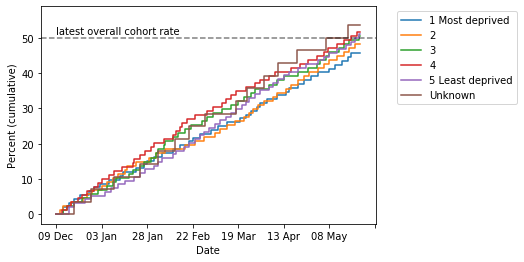

### COVID vaccinations among **50-54** population by **bmi**

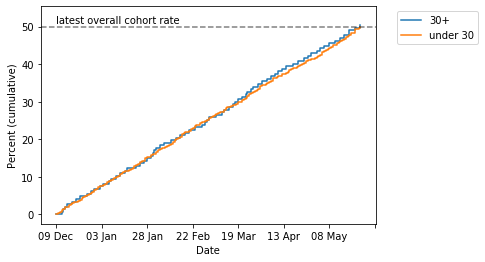

### COVID vaccinations among **50-54** population by **chronic cardiac disease**

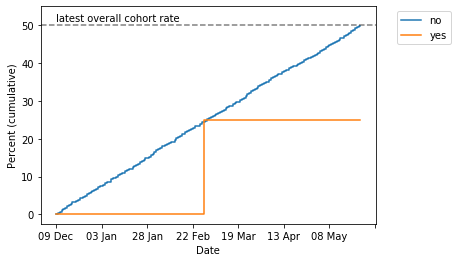

### COVID vaccinations among **50-54** population by **current copd**

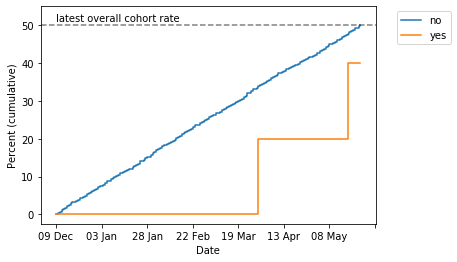

### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

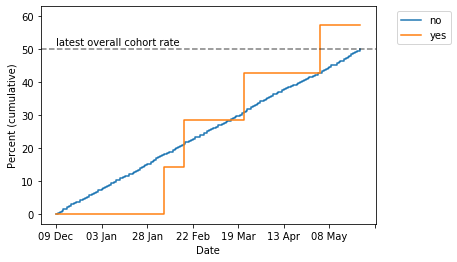

### COVID vaccinations among **50-54** population by **ssri**

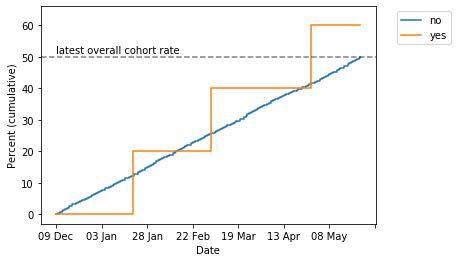

In [25]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [26]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,813 (85.8%)

Total **70-79** population with ethnicity recorded 2,933 (84.1%)

Total **care home** population with ethnicity recorded 1,120 (82.9%)

Total **shielding (aged 16-69)** population with ethnicity recorded 371 (85.5%)

Total **65-69** population with ethnicity recorded 1,946 (85.5%)

Total **LD (aged 16-64)** population with ethnicity recorded 672 (85.0%)

Total **60-64** population with ethnicity recorded 2,247 (84.0%)

Total **55-59** population with ethnicity recorded 2,562 (84.7%)

Total **50-54** population with ethnicity recorded 2,842 (85.3%)

Total **vaccinated 16-49, not in other eligible groups shown** population with ethnicity recorded 25,963 (85.1%)

# Second doses

In [27]:
# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

date_14w = pd.to_datetime(df["covid_vacc_date"]).max() - timedelta(weeks=14)
date_14w = str(date_14w)[:10]

df_s = df.copy()
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

formatted_date_14w = datetime.strptime(date_14w, "%Y-%m-%d").strftime("%d %b %Y")
with open(os.path.join(savepath["text"], f"latest_date_of_first_dose_for_due_second_doses.txt"), "w") as text_file:
        text_file.write(formatted_date_14w)
        
display(Markdown(formatted_date_14w))

16 Feb 2021

In [28]:
population_subgroups_2 = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "16-64, not in other eligible groups shown":0 
        # NB the key for the final group (0) must contain phrase "not in other eligible groups"
        }

groups2 = population_subgroups_2.keys()

df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups_2, features_dict=features_dict, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

In [29]:
second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups2)

In [30]:
create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups2,
                               savepath=savepath, vaccine_type="second_dose")

## 

## COVID vaccination rollout (second dose) among **80+** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     425   
sex                       F                                           217   
                          M                                           203   
ageband_5yr               0                                            28   
                          0-15                                         21   
                          16-29                                        28   
                          30-34                                        28   
                          35-39                                        35   
                          40-44                                        28   
                          45-49                                        28   
                          50-54                                        21   
                          55-59                                        28   
                          60-64                                        28   
                          65-69                                        28   
                          70-74                                        21   
                          75-79                                        28   
                          80-84                                        35   
                          85-89                                        21   
                          90+                                          21   
ethnicity_6_groups        Black                                        77   
                          Mixed                                        70   
                          Other                                        56   
                          South Asian                                  77   
                          Unknown                                      70   
                          White                                        77   
ethnicity_16_groups        African                                     21   
                           Bangladeshi or British Bangladeshi          35   
                           Caribbean                                   21   
                           Chinese                                     28   
                           Other                                       21   
                           Other Asian                                 28   
                          British or Mixed British                     14   
                          Indian or British Indian                     28   
                          Irish                                        21   
                          Other Black                                  28   
                          Other White                                  14   
                          Other mixed                                  21   
                          Pakistani or British Pakistani               14   
                          Unknown                                      56   
                          White + Asian                                21   
                          White + Black African                        21   
                          White + Black Caribbean                      21   
imd_categories            1 Most deprived                              84   
                          2                                            77   
                          3                                            84   
                          4                                            70   
                          5 Least deprived                             91   
                          Unknown                                      21   
bmi                       30+                                         140   
                          under 30                                    287   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (second dose) among **70-79** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     767   
sex                       F                                           378   
                          M                                           385   
ageband_5yr               0                                            42   
                          0-15                                         49   
                          16-29                                        49   
                          30-34                                        42   
                          35-39                                        49   
                          40-44                                        42   
                          45-49                                        63   
                          50-54                                        56   
                          55-59                                        42   
                          60-64                                        56   
                          65-69                                        63   
                          70-74                                        49   
                          75-79                                        42   
                          80-84                                        42   
                          85-89                                        35   
                          90+                                          49   
ethnicity_6_groups        Black                                       147   
                          Mixed                                       126   
                          Other                                       140   
                          South Asian                                  91   
                          Unknown                                     133   
                          White                                       133   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          35   
                           Caribbean                                   35   
                           Chinese                                     35   
                           Other                                       28   
                           Other Asian                                 49   
                          British or Mixed British                     49   
                          Indian or British Indian                     42   
                          Irish                                        35   
                          Other Black                                  42   
                          Other White                                  35   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               49   
                          Unknown                                     126   
                          White + Asian                                42   
                          White + Black African                        35   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             147   
                          2                                           133   
                          3                                           140   
                          4                                           154   
                          5 Least deprived                            154   
                          Unknown                                      35   
bmi                       30+                                         231   
                          under 30                                    539   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (second dose) among **care home** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             283     20.9   1351   
sex                F                   133     19.4    686   
                   M                   147     21.9    672   
ageband_5yr        0                    21     25.0     84   
                   0-15                 21     21.4     98   
                   16-29                14     18.2     77   
                   30-34                14     16.7     84   
                   35-39                 7     10.0     70   
                   40-44                14     16.7     84   
                   45-49                14     20.0     70   
                   50-54                14     15.4     91   
                   55-59                21     30.0     70   
                   60-64                21     27.3     77   
                   65-69                21     27.3     77   
                   70-74                21     23.1     91   
                   75-79                14     15.4     91   
                   80-84                21     21.4     98   
                   85-89                21     21.4     98   
                   90+                  21     21.4     98   
ethnicity_6_groups Black                49     24.1    203   
                   Mixed                42     17.1    245   
                   Other                56     24.2    231   
                   South Asian          42     20.0    210   
                   Unknown              42     18.2    231   
                   White                56     25.0    224   
dementia           no                  280     20.8   1344   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 20.2   
sex                F                                       19.4   
                   M                                       20.8   
ageband_5yr        0                                         25   
                   0-15                                    21.4   
                   16-29                                   18.2   
                   30-34                                   16.7   
                   35-39                                     10   
                   40-44                                   16.7   
                   45-49                                     20   
                   50-54                                   15.4   
                   55-59                                     30   
                   60-64                                   27.3   
                   65-69                                   27.3   
                   70-74                                   23.1   
                   75-79                                   15.4   
                   80-84                                   21.4   
                   85-89                                   21.4   
                   90+                                     21.4   
ethnicity_6_groups Black                                   20.7   
                   Mixed                                   14.3   
                   Other                                   21.2   
                   South Asian                               20   
                   Unknown                                 18.2   
                   White                                     25   
dementia           no                                      20.3   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.7   
sex                F                                       0   
                   M             

## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   91     21.0    434   
newly_shielded_since_feb_15 no                        91     21.3    427   
                            yes                        0      0.0      0   
sex                         F                         42     20.7    203   
                            M                         49     21.9    224   
ageband                     16-29                      7     14.3     49   
                            30-39                     14     25.0     56   
                            40-49                     14     25.0     56   
                            50-59                     14     25.0     56   
                            60-69                     14     25.0     56   
                            70-79                     21     20.0    105   
                            80+                        0      0.0     56   
ethnicity_6_groups          Black                     14     18.2     77   
                            Mixed                     14     18.2     77   
                            Other                     14     20.0     70   
                            South Asian               21     27.3     77   
                            Unknown                    7     11.1     63   
                            White                     21     27.3     77   
imd_categories              1 Most deprived           21     21.4     98   
                            2                         21     21.4     98   
                            3                         14     18.2     77   
                            4                         21     30.0     70   
                            5 Least deprived          14     20.0     70   
                            Unknown                    0      0.0     21   
LD                          no                        91     21.3    427   
                            yes                        0      0.0      7   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                        20   
newly_shielded_since_feb_15 no                                           19.7   
                            yes                                           NaN   
sex                         F                                            20.7   
                            M                                            21.9   
ageband                     16-29                                        14.3   
                            30-39                                          25   
                            40-49                                          25   
                            50-59                                        12.5   
                            60-69                                          25   
                            70-79                                          20   
                            80+                                             0   
ethnicity_6_groups          Black                                        18.2   
                            Mixed                                        18.2   
                            Other                                          20   
                            South Asian                                  27.3   
                            Unknown                                      11.1   
                            White                                        27.3   
imd_categories              1 Most deprived                              21.4   
                            2                                            21.4   
                            3                                            18.2   
                            4                         

## 

## COVID vaccination rollout (second dose) among **65-69** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     485   
sex                       F                                           259   
                          M                                           231   
ethnicity_6_groups        Black                                        70   
                          Mixed                                        91   
                          Other                                        77   
                          South Asian                                  91   
                          Unknown                                      63   
                          White                                        91   
ethnicity_16_groups        African                                     35   
                           Bangladeshi or British Bangladeshi          21   
                           Caribbean                                   28   
                           Chinese                                     35   
                           Other                                       21   
                           Other Asian                                 28   
                          British or Mixed British                     21   
                          Indian or British Indian                     28   
                          Irish                                        21   
                          Other Black                                  28   
                          Other White                                  28   
                          Other mixed                                  21   
                          Pakistani or British Pakistani               28   
                          Unknown                                      77   
                          White + Asian                                28   
                          White + Black African                        28   
                          White + Black Caribbean                      21   
imd_categories            1 Most deprived                              91   
                          2                                            91   
                          3                                            91   
                          4                                            98   
                          5 Least deprived                             98   
                          Unknown                                      21   
bmi                       30+                                         133   
                          under 30                                    350   
chronic_cardiac_disease   no                                          483   
                          yes                                           0   
current_copd              no                                          483   
                          yes                                           0   
dmards                    no                                          476   
                          yes                                           7   
dementia                  no                                          483   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          483   
                          yes                                           0   
LD                        no                                          476   
                          yes                                           7   
ssri                      no                                          483   
                          yes                                           0   
chemo_or_radio            no                                          483   
                          yes                                           0   
lung_cancer               no                               

## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             158     20.0    791   
sex                F                    91     22.0    413   
                   M                    70     18.5    378   
ageband_5yr        0                     7     14.3     49   
                   0-15                  0      0.0     49   
                   16-29                 7     16.7     42   
                   30-34                 7     14.3     49   
                   35-39                14     28.6     49   
                   40-44                 7     20.0     35   
                   45-49                14     28.6     49   
                   50-54                14     25.0     56   
                   55-59                 7     16.7     42   
                   60-64                 0      0.0     49   
                   65-69                14     22.2     63   
                   70-74                14     22.2     63   
                   75-79                 7     12.5     56   
                   80-84                14     33.3     42   
                   85-89                 7     14.3     49   
                   90+                  14     28.6     49   
ethnicity_6_groups Black                28     23.5    119   
                   Mixed                21     15.0    140   
                   Other                35     25.0    140   
                   South Asian          21     15.8    133   
                   Unknown              21     17.6    119   
                   White                35     23.8    147   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 18.8   
sex                F                                       20.3   
                   M                                       16.7   
ageband_5yr        0                                       14.3   
                   0-15                                       0   
                   16-29                                   16.7   
                   30-34                                   14.3   
                   35-39                                   28.6   
                   40-44                                     20   
                   45-49                                   14.3   
                   50-54                                     25   
                   55-59                                   16.7   
                   60-64                                      0   
                   65-69                                   11.1   
                   70-74                                   22.2   
                   75-79                                   12.5   
                   80-84                                   33.3   
                   85-89                                   14.3   
                   90+                                     14.3   
ethnicity_6_groups Black                                   17.6   
                   Mixed                                     15   
                   Other                                     20   
                   South Asian                             15.8   
                   Unknown                                 17.6   
                   White                                     19   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.2   
sex                F                                     1.7   
                   M                                     1.8   
ageband_5yr        0                                       0   
                   0-15                                    0   
                   16-29                                   0   
                   30-34           

## 

## COVID vaccination rollout (second dose) among **16-64, not in other eligible groups shown** population up to 25 May 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    8431   
sex                     F                                          4249   
                        M                                          4179   
ageband                 16-29                                      1036   
                        30-39                                      1085   
                        40-49                                      1001   
                        50-59                                      1015   
                        60-69                                      1050   
                        70-79                                      2156   
                        80+                                        1092   
ethnicity_6_groups      Black                                      1470   
                        Mixed                                      1491   
                        Other                                      1400   
                        South Asian                                1400   
                        Unknown                                    1260   
                        White                                      1414   
ethnicity_16_groups      African                                    441   
                         Bangladeshi or British Bangladeshi         462   
                         Caribbean                                  441   
                         Chinese                                    483   
                         Other                                      427   
                         Other Asian                                469   
                        British or Mixed British                    469   
                        Indian or British Indian                    448   
                        Irish                                       448   
                        Other Black                                 476   
                        Other White                                 406   
                        Other mixed                                 448   
                        Pakistani or British Pakistani              441   
                        Unknown                                    1253   
                        White + Asian                               469   
                        White + Black African                       406   
                        White + Black Caribbean                     441   
imd_categories          1 Most deprived                            1617   
                        2                                          1589   
                        3                                          1589   
                        4                                          1582   
                        5 Least deprived                           1631   
                        Unknown                                     420   
bmi                     30+                                        2492   
                        under 30                                   5936   
chronic_cardiac_disease no                                         8344   
                        yes                                          84   
current_copd            no                                         8337   
                        yes                                          91   
dmards                  no                                         8344   
                        yes                                          84   
ssri                    no                                         8351   
                        yes                                          77   

                                                            vaccinated 7d previous  \
category                group                                                        
overall                 overall                                

## For comparison look at first doses UP TO 14 WEEKS AGO


In [31]:
df_dict_cum_14w = cumulative_sums(
                                  df, groups_of_interest=population_subgroups_2, features_dict=features_dict, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups2
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups2,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     447   
sex                       F                                           224   
                          M                                           224   
ageband_5yr               0                                            28   
                          0-15                                         28   
                          16-29                                        21   
                          30-34                                        28   
                          35-39                                        21   
                          40-44                                        28   
                          45-49                                        21   
                          50-54                                        42   
                          55-59                                        28   
                          60-64                                        28   
                          65-69                                        21   
                          70-74                                        42   
                          75-79                                        21   
                          80-84                                        35   
                          85-89                                        28   
                          90+                                          28   
ethnicity_6_groups        Black                                        84   
                          Mixed                                        70   
                          Other                                        63   
                          South Asian                                  77   
                          Unknown                                      70   
                          White                                        77   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          21   
                           Caribbean                                   21   
                           Chinese                                     28   
                           Other                                       35   
                           Other Asian                                 21   
                          British or Mixed British                     14   
                          Indian or British Indian                     28   
                          Irish                                        28   
                          Other Black                                  21   
                          Other White                                  14   
                          Other mixed                                  28   
                          Pakistani or British Pakistani               21   
                          Unknown                                      56   
                          White + Asian                                21   
                          White + Black African                        28   
                          White + Black Caribbean                      28   
imd_categories            1 Most deprived                              77   
                          2                                            91   
                          3                                            84   
                          4                                            91   
                          5 Least deprived                             77   
                          Unknown                                      28   
bmi                       30+                                         140   
                          under 30                                    301   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     746   
sex                       F                                           364   
                          M                                           385   
ageband_5yr               0                                            42   
                          0-15                                         49   
                          16-29                                        49   
                          30-34                                        35   
                          35-39                                        49   
                          40-44                                        56   
                          45-49                                        70   
                          50-54                                        35   
                          55-59                                        49   
                          60-64                                        49   
                          65-69                                        49   
                          70-74                                        49   
                          75-79                                        49   
                          80-84                                        35   
                          85-89                                        35   
                          90+                                          42   
ethnicity_6_groups        Black                                       126   
                          Mixed                                       133   
                          Other                                       119   
                          South Asian                                 126   
                          Unknown                                     119   
                          White                                       133   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   35   
                           Chinese                                     35   
                           Other                                       35   
                           Other Asian                                 35   
                          British or Mixed British                     35   
                          Indian or British Indian                     49   
                          Irish                                        28   
                          Other Black                                  49   
                          Other White                                  42   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               42   
                          Unknown                                     112   
                          White + Asian                                28   
                          White + Black African                        35   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             140   
                          2                                           133   
                          3                                           154   
                          4                                           154   
                          5 Least deprived                            140   
                          Unknown                                      28   
bmi                       30+                                         224   
                          under 30                                    518   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             293     21.7   1351   
sex                F                   154     22.4    686   
                   M                   140     20.8    672   
ageband_5yr        0                    14     16.7     84   
                   0-15                 21     21.4     98   
                   16-29                14     18.2     77   
                   30-34                21     25.0     84   
                   35-39                21     30.0     70   
                   40-44                14     16.7     84   
                   45-49                14     20.0     70   
                   50-54                14     15.4     91   
                   55-59                21     30.0     70   
                   60-64                21     27.3     77   
                   65-69                21     27.3     77   
                   70-74                14     15.4     91   
                   75-79                21     23.1     91   
                   80-84                21     21.4     98   
                   85-89                14     14.3     98   
                   90+                  21     21.4     98   
ethnicity_6_groups Black                35     17.2    203   
                   Mixed                49     20.0    245   
                   Other                56     24.2    231   
                   South Asian          49     23.3    210   
                   Unknown              56     24.2    231   
                   White                49     21.9    224   
dementia           no                  294     21.9   1344   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 19.8   
sex                F                                       20.4   
                   M                                       18.8   
ageband_5yr        0                                       16.7   
                   0-15                                    21.4   
                   16-29                                   18.2   
                   30-34                                   16.7   
                   35-39                                     30   
                   40-44                                   16.7   
                   45-49                                     20   
                   50-54                                   15.4   
                   55-59                                     30   
                   60-64                                   27.3   
                   65-69                                   27.3   
                   70-74                                   15.4   
                   75-79                                   23.1   
                   80-84                                   21.4   
                   85-89                                   14.3   
                   90+                                     14.3   
ethnicity_6_groups Black                                   17.2   
                   Mixed                                   17.1   
                   Other                                   21.2   
                   South Asian                               20   
                   Unknown                                 21.2   
                   White                                   21.9   
dementia           no                                      19.8   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.9   
sex                F                                       2   
                   M             

## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   86     19.8    434   
newly_shielded_since_feb_15 no                        84     19.7    427   
                            yes                        0      0.0      0   
sex                         F                         42     20.7    203   
                            M                         49     21.9    224   
ageband                     16-29                      7     14.3     49   
                            30-39                      7     12.5     56   
                            40-49                     14     25.0     56   
                            50-59                     14     25.0     56   
                            60-69                     14     25.0     56   
                            70-79                     21     20.0    105   
                            80+                       14     25.0     56   
ethnicity_6_groups          Black                     14     18.2     77   
                            Mixed                     14     18.2     77   
                            Other                     14     20.0     70   
                            South Asian                7      9.1     77   
                            Unknown                   14     22.2     63   
                            White                     21     27.3     77   
imd_categories              1 Most deprived           21     21.4     98   
                            2                         21     21.4     98   
                            3                          7      9.1     77   
                            4                         14     20.0     70   
                            5 Least deprived          14     20.0     70   
                            Unknown                    0      0.0     21   
LD                          no                        84     19.7    427   
                            yes                        0      0.0      7   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      17.1   
newly_shielded_since_feb_15 no                                           16.4   
                            yes                                           NaN   
sex                         F                                            17.2   
                            M                                            18.8   
ageband                     16-29                                           0   
                            30-39                                        12.5   
                            40-49                                        12.5   
                            50-59                                          25   
                            60-69                                          25   
                            70-79                                        13.3   
                            80+                                            25   
ethnicity_6_groups          Black                                        18.2   
                            Mixed                                        18.2   
                            Other                                          20   
                            South Asian                                   9.1   
                            Unknown                                      22.2   
                            White                                        27.3   
imd_categories              1 Most deprived                              21.4   
                            2                                            14.3   
                            3                                             9.1   
                            4                         

## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     499   
sex                       F                                           252   
                          M                                           245   
ethnicity_6_groups        Black                                        84   
                          Mixed                                        91   
                          Other                                        84   
                          South Asian                                  77   
                          Unknown                                      77   
                          White                                        84   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          28   
                           Caribbean                                   28   
                           Chinese                                     35   
                           Other                                       21   
                           Other Asian                                 21   
                          British or Mixed British                     21   
                          Indian or British Indian                     35   
                          Irish                                        21   
                          Other Black                                  28   
                          Other White                                  28   
                          Other mixed                                  28   
                          Pakistani or British Pakistani               28   
                          Unknown                                      77   
                          White + Asian                                21   
                          White + Black African                        21   
                          White + Black Caribbean                      35   
imd_categories            1 Most deprived                              98   
                          2                                            98   
                          3                                            91   
                          4                                            91   
                          5 Least deprived                             98   
                          Unknown                                      21   
bmi                       30+                                         126   
                          under 30                                    371   
chronic_cardiac_disease   no                                          497   
                          yes                                           0   
current_copd              no                                          490   
                          yes                                           0   
dmards                    no                                          497   
                          yes                                           0   
dementia                  no                                          497   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          497   
                          yes                                           0   
LD                        no                                          497   
                          yes                                           0   
ssri                      no                                          497   
                          yes                                           0   
chemo_or_radio            no                                          497   
                          yes                                           0   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             164     20.7    791   
sex                F                    91     22.0    413   
                   M                    77     20.4    378   
ageband_5yr        0                     7     14.3     49   
                   0-15                  7     14.3     49   
                   16-29                 7     16.7     42   
                   30-34                 7     14.3     49   
                   35-39                14     28.6     49   
                   40-44                 0      0.0     35   
                   45-49                14     28.6     49   
                   50-54                14     25.0     56   
                   55-59                 7     16.7     42   
                   60-64                 7     14.3     49   
                   65-69                14     22.2     63   
                   70-74                 7     11.1     63   
                   75-79                14     25.0     56   
                   80-84                14     33.3     42   
                   85-89                14     28.6     49   
                   90+                   7     14.3     49   
ethnicity_6_groups Black                14     11.8    119   
                   Mixed                35     25.0    140   
                   Other                28     20.0    140   
                   South Asian          21     15.8    133   
                   Unknown              28     23.5    119   
                   White                35     23.8    147   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 18.8   
sex                F                                       20.3   
                   M                                       18.5   
ageband_5yr        0                                       14.3   
                   0-15                                    14.3   
                   16-29                                   16.7   
                   30-34                                   14.3   
                   35-39                                   28.6   
                   40-44                                      0   
                   45-49                                   28.6   
                   50-54                                   12.5   
                   55-59                                   16.7   
                   60-64                                   14.3   
                   65-69                                   22.2   
                   70-74                                   11.1   
                   75-79                                     25   
                   80-84                                   16.7   
                   85-89                                   28.6   
                   90+                                     14.3   
ethnicity_6_groups Black                                   11.8   
                   Mixed                                     20   
                   Other                                     20   
                   South Asian                             15.8   
                   Unknown                                 23.5   
                   White                                   23.8   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.9   
sex                F                                     1.7   
                   M                                     1.9   
ageband_5yr        0                                       0   
                   0-15                                    0   
                   16-29                                   0   
                   30-34           

## 

## COVID vaccination rollout (first dose 14w ago) among **16-64, not in other eligible groups shown** population up to 2021-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    8335   
sex                     F                                          4270   
                        M                                          4067   
ageband                 16-29                                      1036   
                        30-39                                      1057   
                        40-49                                      1029   
                        50-59                                      1008   
                        60-69                                      1029   
                        70-79                                      2114   
                        80+                                        1050   
ethnicity_6_groups      Black                                      1470   
                        Mixed                                      1491   
                        Other                                      1379   
                        South Asian                                1337   
                        Unknown                                    1302   
                        White                                      1358   
ethnicity_16_groups      African                                    441   
                         Bangladeshi or British Bangladeshi         420   
                         Caribbean                                  476   
                         Chinese                                    483   
                         Other                                      441   
                         Other Asian                                469   
                        British or Mixed British                    441   
                        Indian or British Indian                    455   
                        Irish                                       434   
                        Other Black                                 441   
                        Other White                                 399   
                        Other mixed                                 434   
                        Pakistani or British Pakistani              448   
                        Unknown                                    1232   
                        White + Asian                               469   
                        White + Black African                       420   
                        White + Black Caribbean                     441   
imd_categories          1 Most deprived                            1547   
                        2                                          1582   
                        3                                          1617   
                        4                                          1617   
                        5 Least deprived                           1561   
                        Unknown                                     406   
bmi                     30+                                        2527   
                        under 30                                   5810   
chronic_cardiac_disease no                                         8246   
                        yes                                          84   
current_copd            no                                         8260   
                        yes                                          70   
dmards                  no                                         8260   
                        yes                                          77   
ssri                    no                                         8239   
                        yes                                          98   

                                                            vaccinated 7d previous  \
category                group                                                        
overall                 overall                                